# What is a Data Scientist?

A _data scientist_ answers questions about _data_.  Given some data and a _business question_ the DS gives a quantitive response.  Some questions that a DS can answer:

* How many units are we going to sell in the next quarter?
* What is our conversion rate for 3, 6 and 12 months?
* Which of our machines will fail this year?

Data Science is a combination of the following:


<img src="https://miro.medium.com/max/993/1*jd_xgOzAFw7rBklREtgOTQ.jpeg" width=400 height=400 />


In essence, data science is about _telling a story_ to stakeholders.  The story should allow stakeholders to understand the reasoning behind the answer and where it comes from.  A good data scientist tells great stories...

[TEDx - The Magical Science of Storytelling](https://www.youtube.com/watch?v=Nj-hdQMa3uA)

The above notwithstanding, in this talk we'll do something different.  Rather than a well-defined business question - which is critical in a good data science project - we'll look at some data and do what is known as *Exploratory Data Analysis*.  That is, we'll get a feeling for some data and see what questions can be relevant.


# Our Data for Today

Our data consists of metadata (that is - data _about_ data) for a well-known political page on Facebook.  Our _Data Engineer_ setup a pipeline for scraping and initial pre-processing, so we get new data every week.  It's now time for us to get to work.

The tools we'll be using:
* Python - The swiss-army knife of the Internet.  Has libraries for pretty much anything you can think of.  It has an exceptionally good data-science set of tools.
* Pandas - A library for working with data frames.  A data frame is very similiar to an Excel spreadsheet - data is organized in lines and columns.  We can then do a lot of interesting things with this data.
* Numpy - A set of highly-optimized routines for dealing with arrays of numbers.  
* Matplotlib - A set of basic primitives for doing plots and charts
* Seaborn - A library for doing common statistical plots
* Statsmodels - A library for fitting regression model
* pymc3 - A library for runing Markov-Chain Monte-Carlo (MCMC) simulations

## Cleaning Up and Preparing the Data for Analysis

Real-life data is often messy and un-organized.  We need to make sure that it's "clean" and relevant in order for us to get to work.  Luckily, our data engineer is a good sport and gives us CSV files.  Let's get started!!

In [13]:
#  Load numpy and friends
%pylab inline   
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import pymc3 as pm

# Set some defaults
rcParams['figure.figsize'] = (20,7)
style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('./data.csv')

print("Length of data: ", len(df))
df.head()

Length of data:  2849


,post_time,likes,comments,shares,love,support,wow,haha,anger,sorry,words,has_image,fetched_time
0,07/05/2020 08:30:33,321,104,75,0,0,5,1,120,1,107,False,07/05/2020 08:52:40
1,07/05/2020 07:30:00,2711,190,113,105,24,3,551,1,0,6,True,07/05/2020 08:52:42
2,06/05/2020 23:15:47,6229,597,228,413,55,6,419,2,0,29,True,07/05/2020 08:52:42
3,06/05/2020 21:36:24,1556,77,122,4,5,9,0,147,126,129,True,07/05/2020 08:52:43
4,06/05/2020 17:22:27,2292,619,255,5,1,8,5,539,18,172,True,07/05/2020 08:52:44


So we see the following kind of data:
* Time values (post_time, fetched_time)
* Numerical values
* Boolean 

Is this what pandas thinks?

In [3]:
df.dtypes

post_time       object
likes            int64
comments         int64
shares           int64
love             int64
support          int64
wow              int64
haha             int64
anger            int64
sorry            int64
words            int64
has_image         bool
fetched_time    object
dtype: object

All seems well, except the time fields, which are treated as generic objects.  Let's change that so that we can apply time functions.

In [4]:
df.post_time = pd.to_datetime(df.post_time, dayfirst=True)
df.fetched_time = pd.to_datetime(df.fetched_time, dayfirst=True)

df.dtypes

post_time       datetime64[ns]
likes                    int64
comments                 int64
shares                   int64
love                     int64
support                  int64
wow                      int64
haha                     int64
anger                    int64
sorry                    int64
words                    int64
has_image                 bool
fetched_time    datetime64[ns]
dtype: object

Much better!  Now let's look at the numerical values - anything out of range?  

In [5]:
df.describe()

,likes,comments,shares,love,support,wow,haha,anger,sorry,words
count,2849.000000,2849.000000,2849.000000,2849.000000,2849.000000,2849.000000,2849.000000,2849.000000,2849.000000,2849.000000
mean,3430.947701,546.000000,598.480870,61.679888,1.553879,7.590383,65.555283,100.041418,50.162513,46.194805
std,4079.053283,808.377774,1507.830545,278.938749,40.422505,29.065084,327.354142,347.939226,337.575695,41.838578
min,86.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1022.000000,137.000000,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000
50%,2127.000000,292.000000,212.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000
75%,4311.000000,639.000000,558.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000
max,51115.000000,13896.000000,32329.000000,4899.000000,1980.000000,578.000000,7385.000000,3776.000000,8409.000000,214.000000


Looks good.  Some interesting points that can be spotted:
* The more specific 'like' types are often not used.
* The shortest post is 1 word long
* Number of likes is usually around 1 order-of-magnitude larger than anything else

Note also the 'count' field - this means that there are no missing values.  Real data often does have some.

How about the non-numerical fields?

In [6]:
print(df['post_time'].describe(), "\n")
print(df['fetched_time'].describe(), "\n")
print(df['has_image'].describe())

count                    2849
unique                   2849
top       2019-12-19 12:00:43
freq                        1
first     2016-04-12 13:08:59
last      2020-05-07 08:30:33
Name: post_time, dtype: object 

count                     714
unique                    674
top       2020-05-07 08:56:01
freq                        2
first     2020-05-07 08:52:40
last      2020-05-07 09:12:29
Name: fetched_time, dtype: object 

count      2849
unique        2
top       False
freq       1733
Name: has_image, dtype: object


Hmm, looks like there is a issue with the `fetched_time` field.  There are only 714 values but our data has 2849 values!  Seems like a bug, as `fetched_time` is data that our scraping software adds.  We'll alert our data engineer colleague but in the meantime - what do we do?

Here's where we need to think.  Do we -
* Remove this field?
* 'Fill it in' somehow?  (The technical term is 'imputate')

Since `fetched_time` is just a technical field that we added, how about we just fill in the values with the latest available `fetched_time`?  This should be a good approximation. 

In [7]:
latest_time = df.fetched_time.max()
df['fetched_time'].fillna(latest_time, inplace=True)

df['fetched_time'].describe()

count                    2849
unique                    674
top       2020-05-07 09:12:29
freq                     2136
first     2020-05-07 08:52:40
last      2020-05-07 09:12:29
Name: fetched_time, dtype: object

Almost there.  Just another small issue:  we're dealing with reactions to Facebook posts.  Obviously, this is time-dependent in the sense that posts stay 'fresh' for a while and keep on getting likes, shares and so on.  So if we catch a post while it's still 'fresh', it might not have gotten everything it could get.

Ideally, we could model how long a post is considered fresh for this page and ignore those.  But we only have total reactions and not the specific times.  So we make assumptions.  Let's a post stays fresh for 48 hours since users may not enter Facebook every single day and might react with a certain time delay.  

How can we tell what posts are fresh?  We compare the `fetched_time` and `post_time` fields.  Let's add an `age` field and `is_fresh` field to the data.

In [8]:
(df['fetched_time'] - df['post_time']).head(20)

0    0 days 00:22:07
1    0 days 01:22:42
2    0 days 09:36:55
3    0 days 11:16:19
4    0 days 15:30:17
5    0 days 22:52:12
6    1 days 00:21:59
7    1 days 01:22:26
8    1 days 16:13:59
9    1 days 21:04:52
10   1 days 22:52:46
11   2 days 00:22:30
12   2 days 01:22:44
13   2 days 10:38:49
14   2 days 10:54:45
15   2 days 19:54:42
16   2 days 22:52:51
17   3 days 00:22:40
18   3 days 01:22:57
19   3 days 16:41:20
dtype: timedelta64[ns]

In [9]:
df['age'] = (df['fetched_time'] - df['post_time']).apply(lambda delta: delta.days )
df['is_fresh'] = df['age'] < 2
df.head(15)

,post_time,likes,comments,shares,love,support,wow,haha,anger,sorry,words,has_image,fetched_time,age,is_fresh
0,2020-05-07 08:30:33,321,104,75,0,0,5,1,120,1,107,False,2020-05-07 08:52:40,0,True
1,2020-05-07 07:30:00,2711,190,113,105,24,3,551,1,0,6,True,2020-05-07 08:52:42,0,True
2,2020-05-06 23:15:47,6229,597,228,413,55,6,419,2,0,29,True,2020-05-07 08:52:42,0,True
3,2020-05-06 21:36:24,1556,77,122,4,5,9,0,147,126,129,True,2020-05-07 08:52:43,0,True
4,2020-05-06 17:22:27,2292,619,255,5,1,8,5,539,18,172,True,2020-05-07 08:52:44,0,True
5,2020-05-06 10:00:34,3299,346,207,10,0,10,300,360,11,121,True,2020-05-07 08:52:46,0,True
6,2020-05-06 08:30:48,5455,448,456,39,9,11,1,407,2248,133,True,2020-05-07 08:52:47,1,True
7,2020-05-06 07:30:21,3197,815,546,5,0,103,25,1062,40,19,False,2020-05-07 08:52:47,1,True
8,2020-05-05 16:38:49,3957,1034,326,6,0,37,13,1218,183,48,False,2020-05-07 08:52:48,1,True
9,2020-05-05 12:07:37,2758,1086,264,0,0,0,0,0,0,30,False,2020-05-07 09:12:29,1,True


We can now create another dataframe which includes only 'stale' posts which have reached a stable state.

In [10]:
df_stale = df[df.is_fresh == False].copy()

Good to go!  Now we can start having fun.

## Getting to Know the Data

So the first question that comes to mind is what does the distribution of post ages look like?

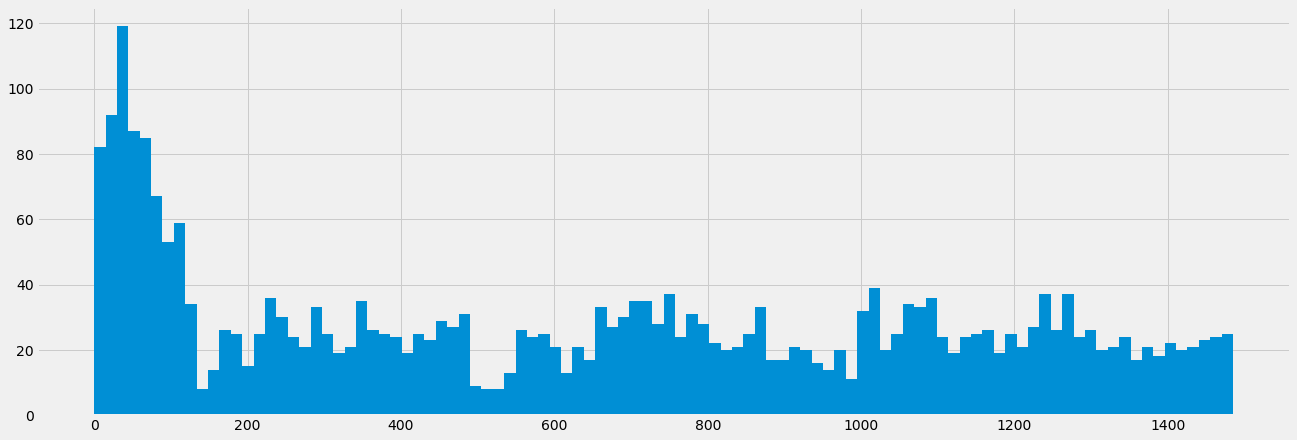

In [14]:
df['age'].hist(bins=100)

Intersting.  It seems that the volume of activity has increased over the last 6 months of so.  Before that there also seem to be periods of more or less activity but not as intense. 

Let's see if we can find some correlations in the data.

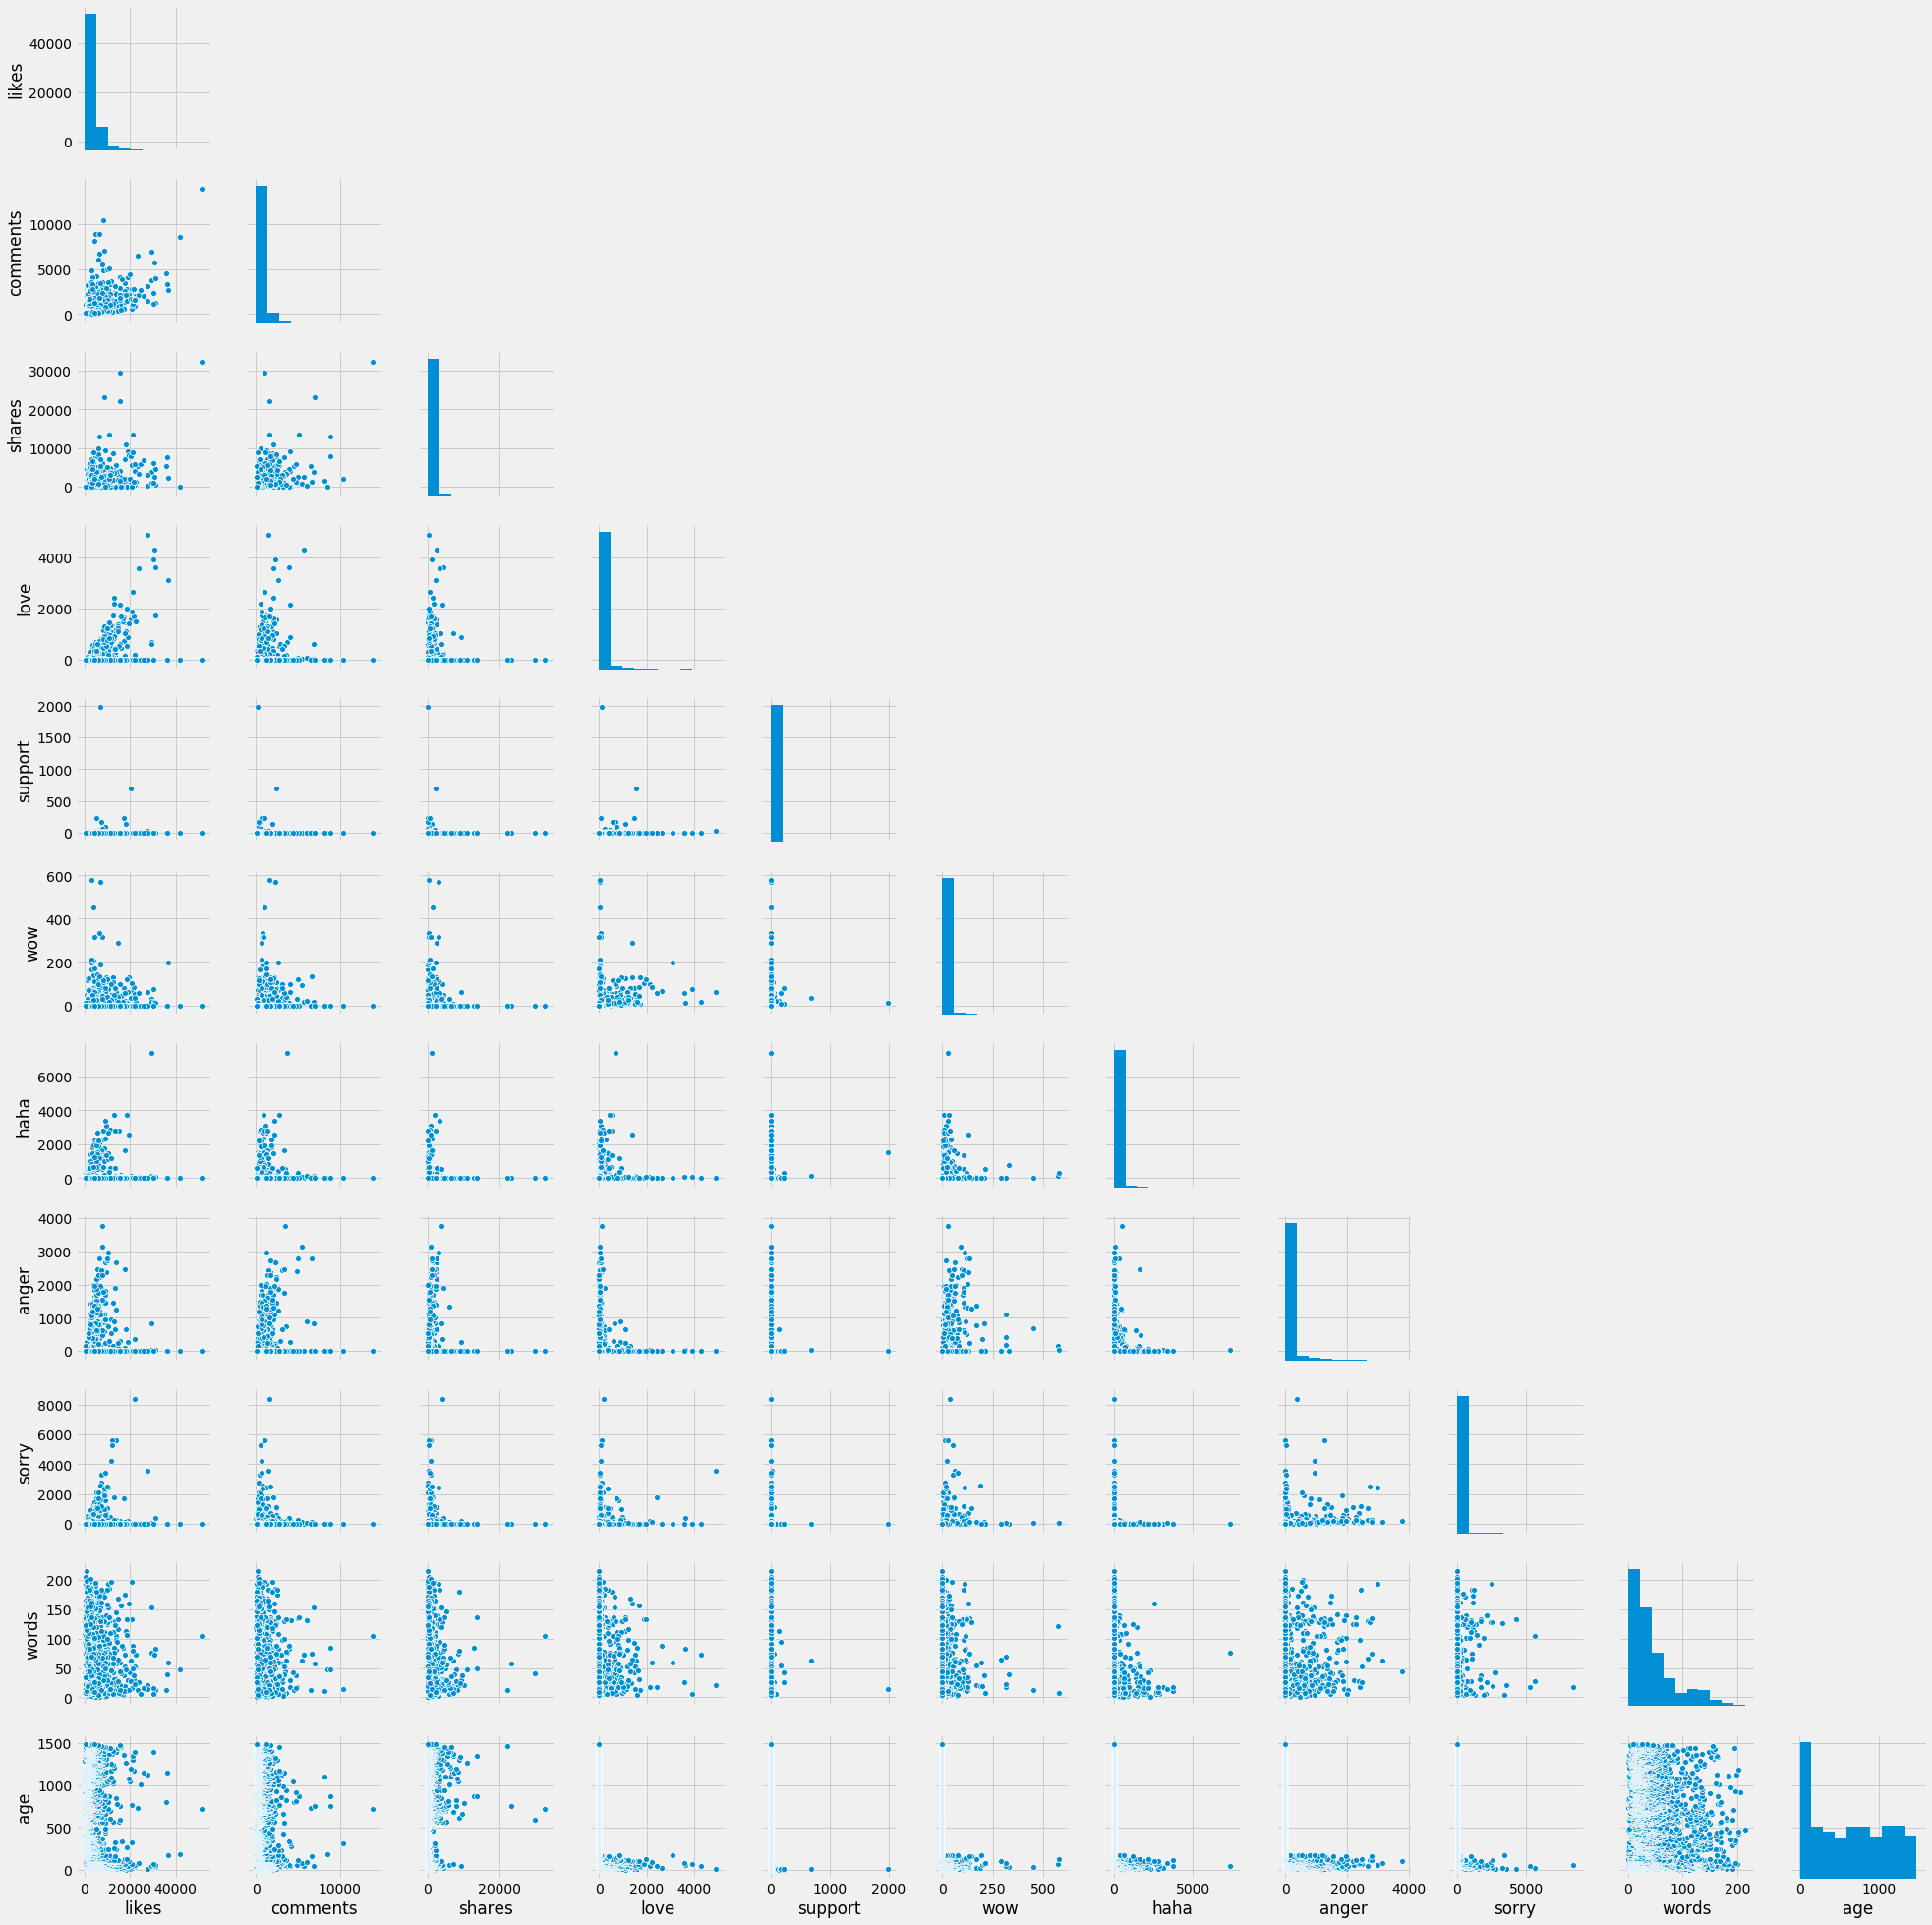

In [15]:
time_columns = ['post_time','fetched_time']
bool_columns = ['has_image', 'is_fresh']

def hide_current_axis(*args, **kwds):
    gca().set_visible(False)
    
    
numerical_columns = [col for col in df.columns if col not in time_columns + bool_columns]
pair_plot = sns.pairplot(df_stale[numerical_columns])
pair_plot.map_upper(hide_current_axis)

There don't seem to be any super-obvious correlations between numerical metrics of a post.  There might be some connections between the the number of `likes` and `sorry`, `anger`, and `love`.  That makes sense, as these are all expressions of emotion.  

But it does look like there's some sort of pattern between `age` and `likes`, `comments` and `shares`.  Let's take a closer look.

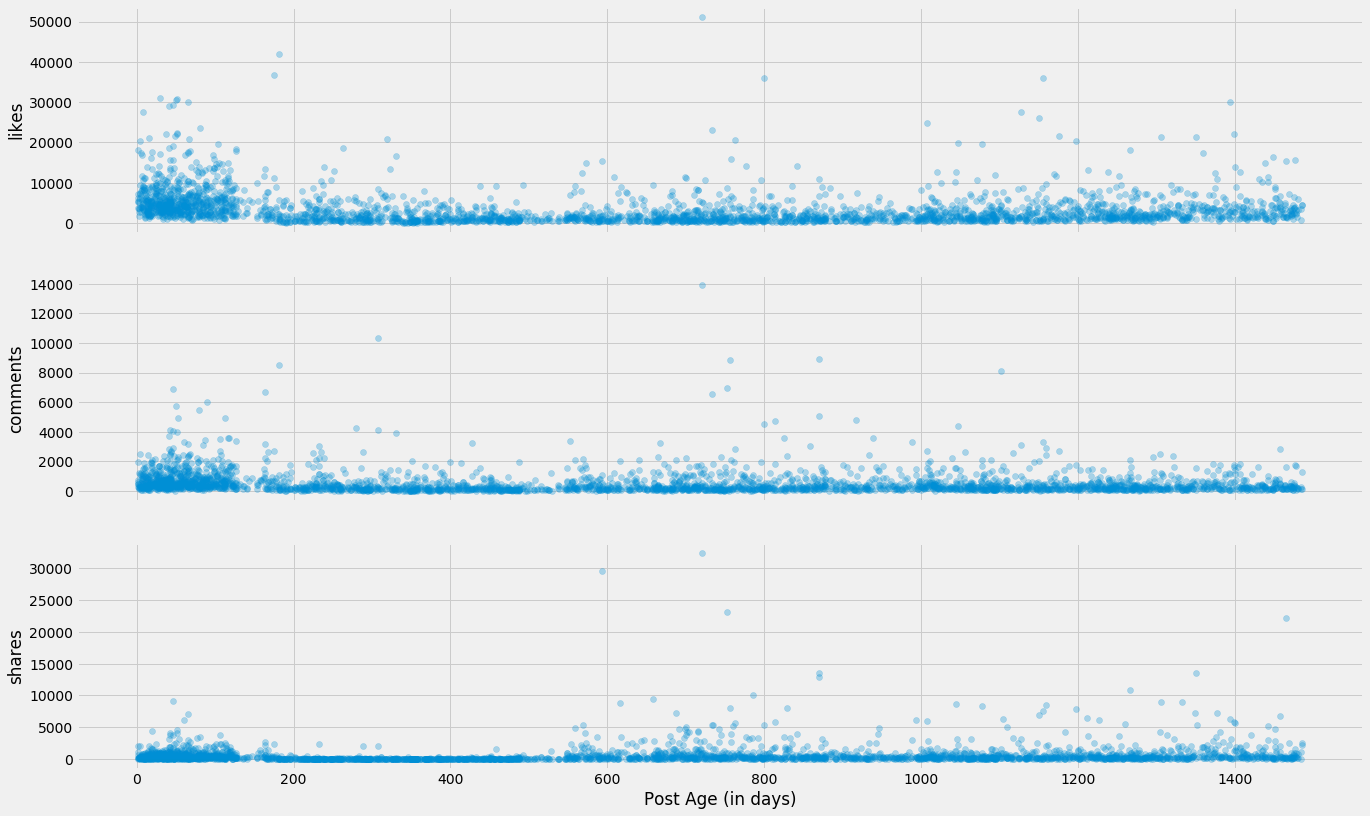

In [16]:
y_vars = ['likes','comments','shares']

fig, axs = subplots(3,1, sharex=True, figsize=(20,12))
for y_var, this_ax in zip(y_vars, axs):
    this_ax.scatter(df_stale['age'], df_stale[y_var], alpha=0.3)
    this_ax.set_ylabel(y_var)
    
fig.tight_layout(pad=3)
xlabel("Post Age (in days)");

OK, definitely something going on in the last 6 months or so.  It seems that the minimum number of likes for posts have increased.  There also seems to be a change in the amounts of comments and maybe a small change in the amount of shares.  Could this be a cycle where the author is inspired to write more because of responses which in turn bring more responses and so on?

Let's look at the how long each post was published after the previous one.

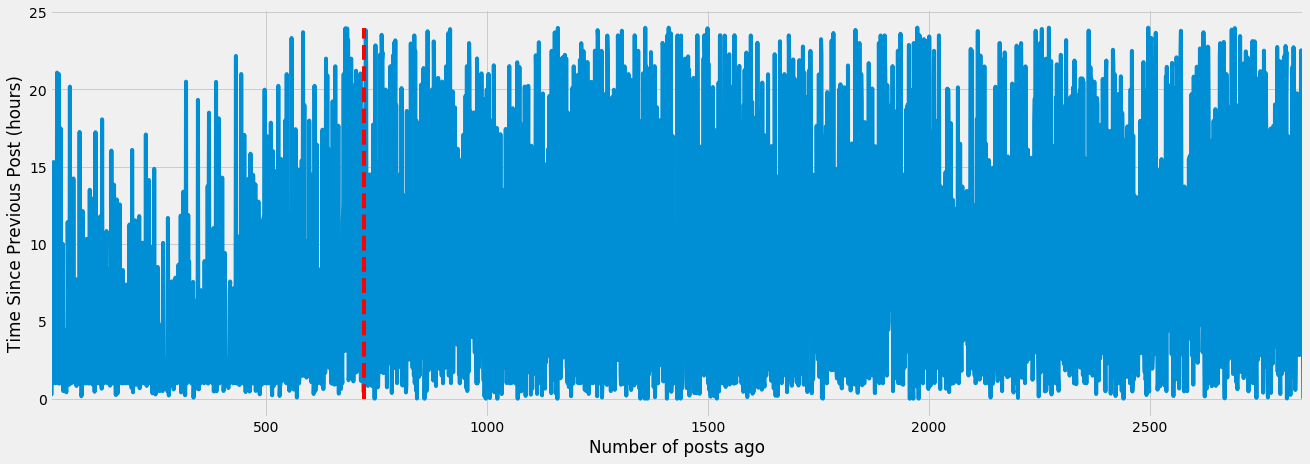

In [17]:
df_stale['time_since_previous'] = (df_stale['post_time'] - df_stale['post_time'].shift(-1)) \
    .apply(lambda x: x.seconds / (60 * 60)).fillna(0)

# What was the date 180 days ago?
date_6_months_ago = df_stale['post_time'].max()- pd.Timedelta(days=180)

# How many posts were published since then?
num_posts_last_6_months = len(df_stale[df_stale['post_time'] >= date_6_months_ago])


ax = subplot()
df_stale['time_since_previous'].plot(ax=ax, zorder=2)
ax.set_xlabel("Number of posts ago")
ax.set_ylabel("Time Since Previous Post (hours)");
ax.vlines(num_posts_last_6_months, 0, df_stale['time_since_previous'].max(), 'red', '--', zorder=3)

So it's probably less than 6 months. There are additional techniques that can help us figure out exactly when, but we won't deal with them here.

Let's look at something else.  Does having an image make a difference in the amount of responses to a post?

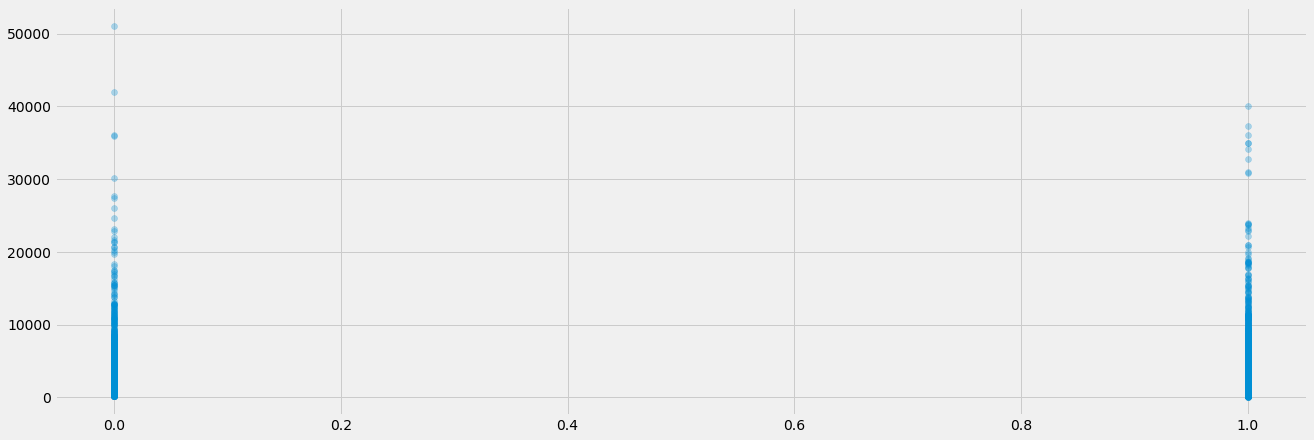

In [18]:
df_stale['total_responses'] = 0

# Just 'likes' and similiar - is this right?
for col in ['likes', 'love', 'support', 'wow', 'haha', 'anger', 'sorry']:
    df_stale['total_responses'] += df_stale[col]
    
    
scatter(df_stale['has_image'], df_stale['total_responses'], alpha=0.3);

Kind of hard to tell whether adding an image to the post makes a difference.  Intuition is that it does - so this is exactly the place to apply machine learning techniques and get a quantitive answer.  We'll apply a tool called _linear regression_ which will allow us to measure how large this effect is.

In [19]:
linear_regression_model = smf.ols('total_responses ~ has_image', data=df_stale).fit()
linear_regression_model.summary()

/Users/yuvalm/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        total_responses   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     79.43
Date:                Sat, 19 Jun 2021   Prob (F-statistic):           8.73e-19
Time:                        10:08:00   Log-Likelihood:                -27857.
No. Observations:                2838   AIC:                         5.572e+04
Df Residuals:                    2836   BIC:                         5.573e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          3120.1556    106.645     29.257      0.000    2911.046    3329.266
has_image[T.True]  1520.4864    170.601      8.913      0.000    1185.972    1855.001
==============================================================================
Omnibus:                     2151.805   Durbin-Watson:                   1.534
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            47674.684
Skew:                           3.433   Prob(JB):                         0.00
Kurtosis:                      21.869   Cond. No.                         2.44
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Lots of metrics, most of which are irrelevant for us right now.  What we are interested in is the second table. It tells us that a post without images gets *on average* 3120 responses and an image adds (again, on average) 1520 additional responses.  It is also worthwhile looking at how confident the model is about these results, although we will not do that here.  The effect is positive, although it may not be very big.  Let's see this in graphical form:

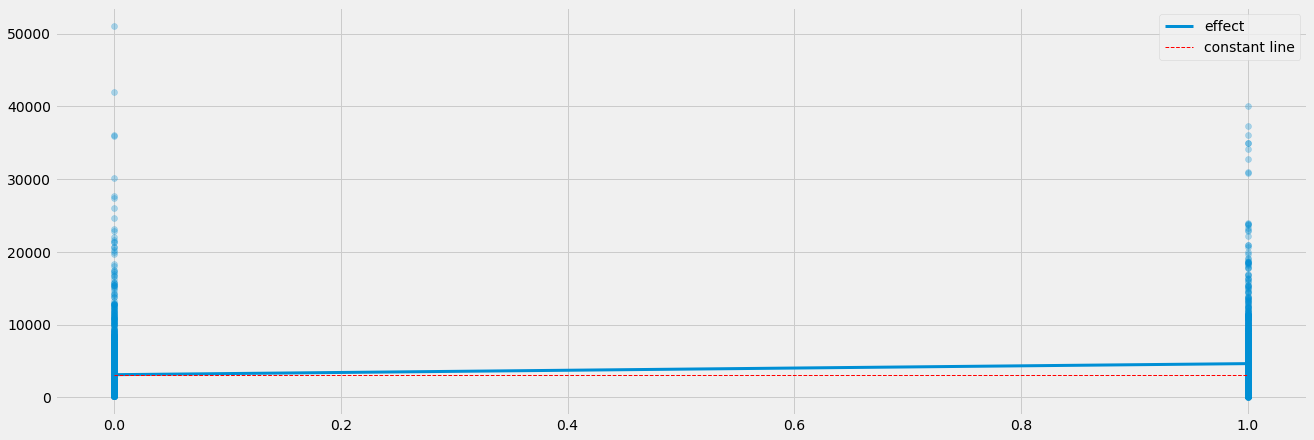

In [20]:
intercept, slope = linear_regression_model.params

scatter(df_stale['has_image'], df_stale['total_responses'], alpha=0.3)
xs = np.arange(0,1.01,0.01)
plot(xs, intercept + slope*xs, linewidth=3, label='effect')
plot(xs, intercept + 0*xs, 'r--', linewidth=1, label='constant line')
legend();

Let's look at yet another characteristic of the data.  What is the median number of responses we get when we post at a given day of week/hour?  We use the median because there is a lot of variance in the data which the mean (average) is sensitive to.

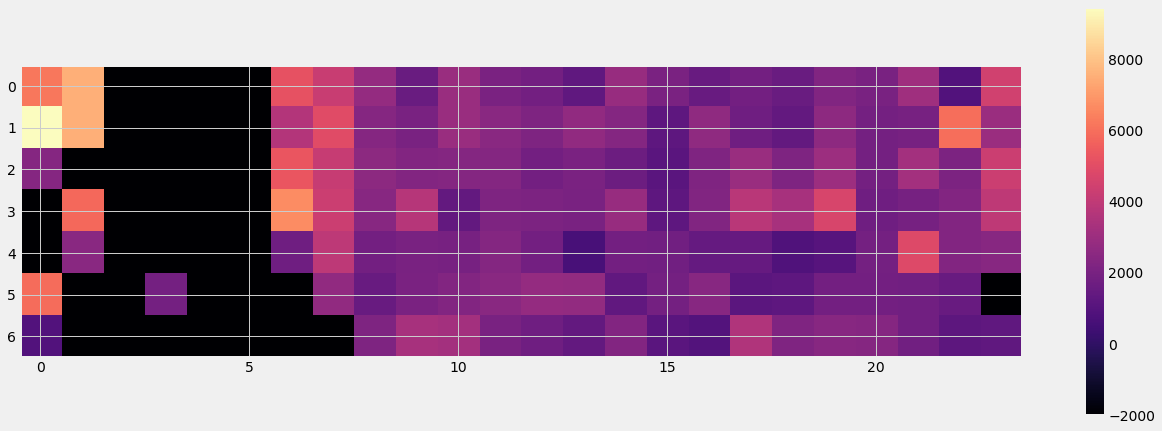

In [21]:
# Break down 'time' into day of way and hour
df_temp = df_stale[['post_time','total_responses']].copy()
df_temp['post_day'] = df_temp['post_time'].apply(lambda t : (t.dayofweek + 1) % 7) # Adjust for Sunday == 0
df_temp['post_hour'] = df_temp['post_time'].apply(lambda t : t.hour)

# Group by DOW and hour and get median number of responses
df_temp = df_temp.groupby(['post_day', 'post_hour']).median().reset_index()
df_temp.index = pd.MultiIndex.from_frame(df_temp[['post_day','post_hour']])

# Build grid of data
grid = np.ones((7,24)) * -2000
for ((day, hour), row) in df_temp.iterrows():
    grid[day,hour] = row['total_responses']
    
# Show grid graphically - Monday is 0, Sunday is 6
imshow(grid, cmap='magma')
colorbar();

In this heatmap we can clearly see the areas where we don't have any data (black).  It would also appear that a lot of activity happens on posts that are submitted either early in the morning (earlier than 9AM) or late in the evening (later than 9PM).

Let's also look at the connection between number of words and the amount of responses.

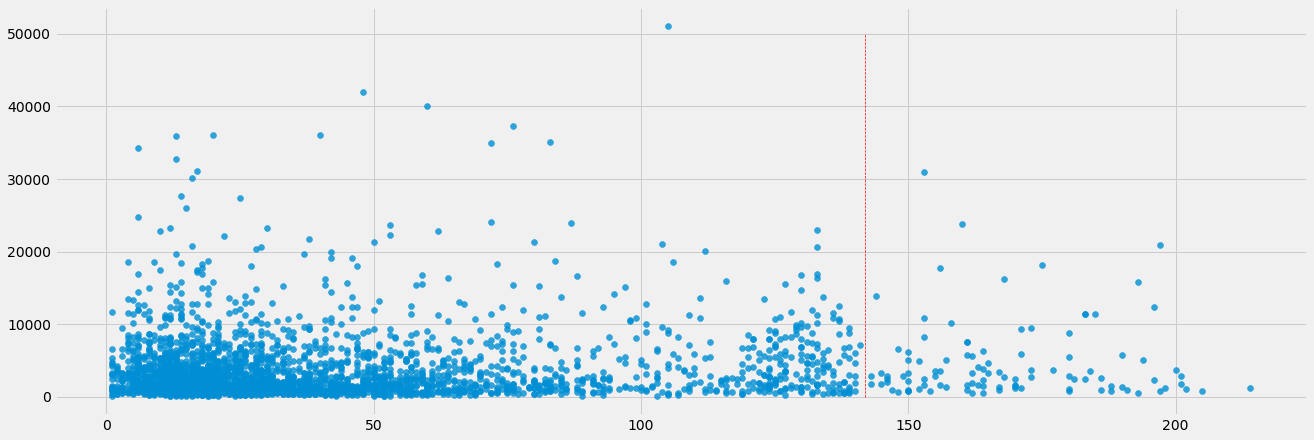

In [24]:
scatter(df_stale['words'], df_stale['total_responses'], alpha=0.8)
vlines(142, 0, 50000, 'red', '--', linewidth=0.7)

No obvious patterns, except maybe for the fact that the author does not like posts that are longer than around 140 words.  Let's look at a histogram of post lengths, along with their median:

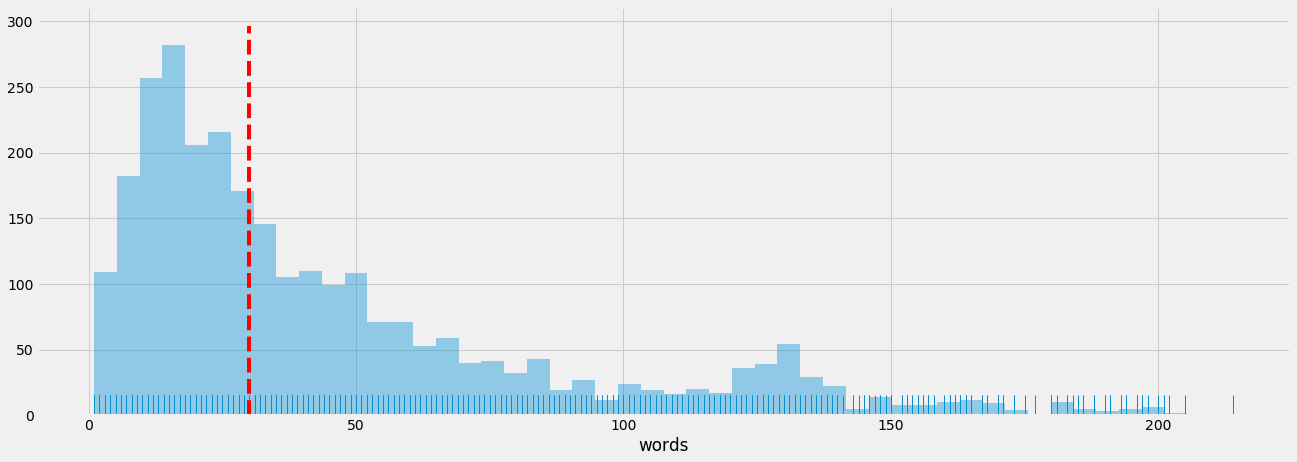

In [25]:
axes = sns.distplot(df_stale['words'], kde=False, rug=True, bins=50)
vlines(df_stale['words'].median(), 0, axes.get_ylim()[1], 'red', '--')

So it's clear the author prefers short posts - most posts are under 50 words long.  The histogram has a peculiar shape though - if we can find something that gives us similiar histograms we might be able to get some insights into what's going on.

For fitting this *distribution* of data, we'll apply a simulation technique called Markov-Chain Monte Carlo.  Essentially what we'll try to do is describe the process that *generates* this data (which is why this is known as *generative* model) by using statistical objects known as *probability distributions*.  If our simulation is good, we'll be able to generate fake data that appears similiar to the real data.  We'll then be able to reason about what exactly is going on.  For this model we'll use a distribution known as the *negative binomial* and try to estimate its two parameters, $ \alpha $ and $ \mu $.

/Users/yuvalm/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 18 seconds.
/Users/yuvalm/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
alpha  46.089  0.728  44.696   47.412      0.009    0.006    7185.0  7180.0   
mu      0.350  0.025   0.302    0.395      0.000    0.000    7187.0  7161.0   

       ess_bulk  ess_tail  r_hat  
alpha    7174.0    5884.0    1.0  
mu       7156.0    5537.0    1.0  


/Users/yuvalm/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13e748320>,
      dtype=object)

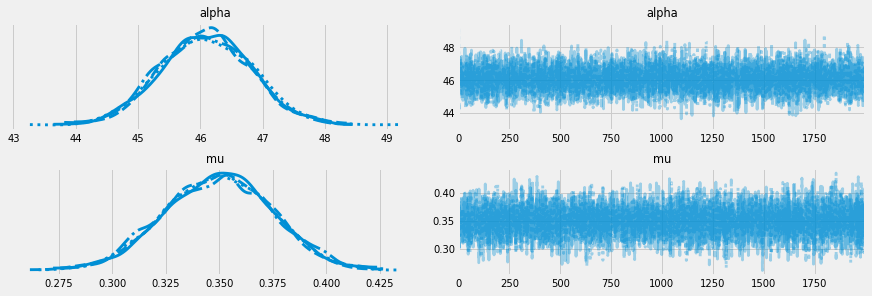

In [29]:
from arviz import summary, plot_trace
with pm.Model() as post_length_model:
    alpha = pm.Normal('alpha', 45, 5)  
    mu = np.exp(pm.Normal('mu', 2, 2))
    words = pm.NegativeBinomial('words', alpha, mu, observed=df_stale['words'])
    trace = pm.sample(2000)
    
#print(pm.summary(trace))
#pm.traceplot(trace)

print(summary(trace))
plot_trace(trace)

The above plots mean that  our simulation has converged - $ \alpha $ appears to have a value between 45 and 48 while $ mu $ has a value between 0.3 and 0.425 (left side plots).  We can also see that the simulation tried many values in this range (right side plots).  

Given these parameters, let's try to use the negative binomial to create ('generate') fake data.  We'll then plot this data against the real data and see if it looks similiar.

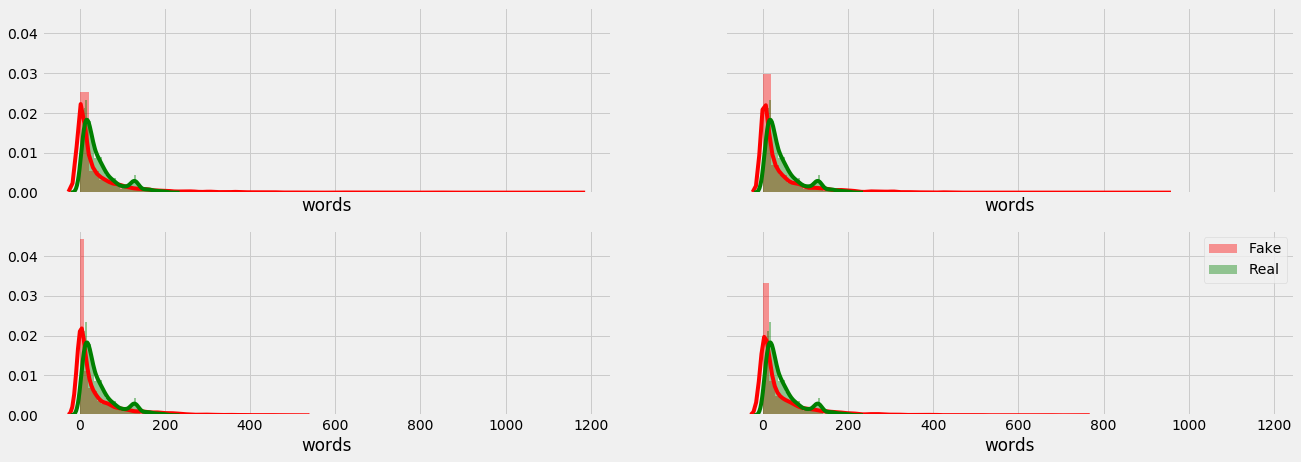

In [32]:
fake_data = pm.NegativeBinomial.dist(trace['alpha'].mean(), trace['mu'].mean()).random(size=(4, len(df_stale)))

fig, axs = subplots(2,2, sharex=True, sharey=True,squeeze=True)

for idx, ax in enumerate(axs.ravel()):
    sns.distplot(fake_data[idx], ax=ax, bins=50, color='red', hist_kws={'alpha': 0.4}, label='Fake')
    sns.distplot(df_stale['words'], ax=ax, bins=50, color='green', hist_kws={'alpha': 0.4}, label='Real')
    
legend()

Looks like our simulation gave us a good approximation!  The functional form appears similiar even if the details are not identical.  We can probably safely try to analyze our author's behavior by thinking about what happens with negative binomial data.  In general, the negative binomial is a *mixture model* - it means that there are many instances of the same phenomenon, but with different parameters.  These parameters, however, are not random but also have rules as to how they are selected.  For a simple example, think of a road on which only cars of the same make and model (for instance, a 2019 Hyundai Ioniq) drive but with a speed that is between 80 and 110 km/h.  

When applying this kind of process to our data, we can think of 2 different theories:

1.  The author has many ideas, and different opinions on each idea.  Each such opinion has a rule ('distribution') on the number of words it requires to express.  Now imagine that our author randomly chooses how many posts they will post on a given day according to some other rule and what idea will be in each post.  Therefore, each post will then comply with its specific set of possible lengths.
2.  A different interpreation of the data may include *multiple* authors, each with their own style of writing.  Every day, a random number of authors are chosen by some rule to write a number of posts.  Each post then has the length that relates to its author's style.

# Summary

In this talk we saw some of the work that a data scientist performs.  In particular, we saw examples of:

* Data cleanup and imputation
* The process of coming up with a theory and then proving/disproving it, using data aggregation and modelling
* Some python tools for doing the above

For this session we only focused on doing some exploratory work on the data and getting familiar with it.  Of course, given a focused business question, the same tools (and many more) can be applied in the same way.
